# Quickstart

VIABEL currently supports both standard KL-based variational inference (KLVI) and chi-squared variational inference (CHIVI). Models are provided as Autograd-compatible log densities or can be constructed from PyStan fit objects.

As a simple example, we consider Neal's funnel distribution in 2 dimensions so that we can visualize the results.

In [1]:
import autograd.numpy as np
import autograd.scipy.stats.norm as norm

D = 2  # number of dimensions
log_sigma_stdev = 1. # 1.35
def log_density(x):
    mu, log_sigma = x[:, 0], x[:, 1]
    sigma_density = norm.logpdf(log_sigma, 0, log_sigma_stdev)
    mu_density = norm.logpdf(mu, 0, np.exp(log_sigma))
    return sigma_density + mu_density

### Black-box Variational Inference

VIABEL's `bbvi` function provides reasonable defaults: the objective is the ELBO (i.e., the including Kullback-Leibler divergence), a mean-field Gaussian approximation family, and windowed version of adagrad for stochastic optimization. Here, rather than the default, we use a mean-field Student *t*-distribution with 10 degrees of freedom.

In [2]:
from viabel import bbvi, MFStudentT
results = bbvi(D, n_iters=5000, log_density=log_density, approx=MFStudentT(D, 10))

Average Loss = 3.6694: 100%|██████████| 5000/5000 [00:15<00:00, 326.32it/s]


We can then plot contours the from the approximation Gaussian (red) and the target funnel distribution (black)

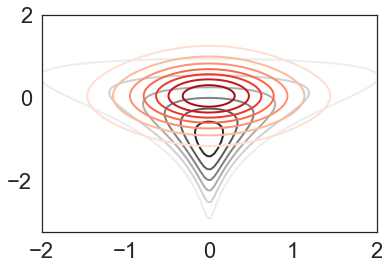

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('white')
sns.set_context('notebook', font_scale=2, rc={'lines.linewidth': 2})

def plot_approx_and_exact_contours(log_density, approx, var_param,
                                   xlim, ylim, cmap2='Reds', savepath=None):
    xlist = np.linspace(*xlim, 100)
    ylist = np.linspace(*ylim, 100)
    X, Y = np.meshgrid(xlist, ylist)
    XY = np.concatenate([np.atleast_2d(X.ravel()), np.atleast_2d(Y.ravel())]).T
    zs = np.exp(log_density(XY))
    Z = zs.reshape(X.shape)
    zsapprox = np.exp(approx.log_density(var_param, XY))
    Zapprox = zsapprox.reshape(X.shape)
    plt.contour(X, Y, Z, cmap='Greys', linestyles='solid')
    plt.contour(X, Y, Zapprox, cmap=cmap2, linestyles='solid')
    plt.xlim(xlim)
    plt.ylim(ylim)
    if savepath is not None:
        plt.savefig(savepath, bbox_inches='tight')
    plt.show()

plot_approx_and_exact_contours(log_density, results['objective'].approx, results['var_param'], 
                               xlim=[-2, 2], ylim=[-3.25, 2], savepath='funnel.png')

### Diagnostics

VIABEL also has a suite of diagostics for variational inference. We can easily run these using the `vi_diagnostics` function, although low-level support is also provided. 

In [4]:
from viabel import vi_diagnostics
import warnings
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    diagnostics = vi_diagnostics(results['var_param'], objective=results['objective'], n_samples=100000)

Pareto k is estimated to be khat = 0.67

The 2-divergence is estimated to be d2 = 4.7


### Importance Sampling

The Pareto-smoothed weights provide a fairly accuracy approximation. 

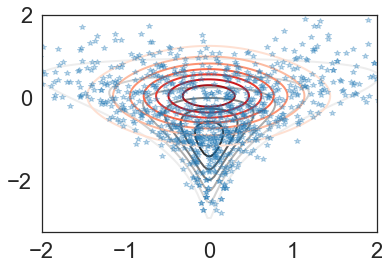

In [5]:
weights = np.exp(diagnostics['smoothed_log_weights'])
all_samples = diagnostics['samples']

# for illustation, sample 1000 weights for visualization
subset = np.random.choice(all_samples.shape[1], size=1000, p=weights)
samples = all_samples[:,subset]
plt.plot(samples[0], samples[1], '*', alpha=.3)
plot_approx_and_exact_contours(log_density, results['objective'].approx, results['var_param'], 
                               xlim=[-2, 2], ylim=[-3.25, 2], savepath='funnel-psis-samples.png')